# TSSL Lab 2 - Structural model, Kalman filtering and EM
We will continue to work with the Global Mean Sea Level (GMSL) data that we got acquainted with in lab 1. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

In this lab we will analyse this data using a structural time series model. We will first set up a model and implement a Kalman filter to infer the latet states of the model, as well doing long-term prediction. We will then implement a disturbance smoother and an expectation maximization algorithm to tune the parameters of the model.

We load a few packages that are useful for solving this lab assignment.

In [2]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)  # Increase default size of plots

## 2.1 Setting up a structural state space model

We start by loading and plotting data to reming ourselves what it looks like.

In [3]:
data=pandas.read_csv('sealevel.csv',header=0)

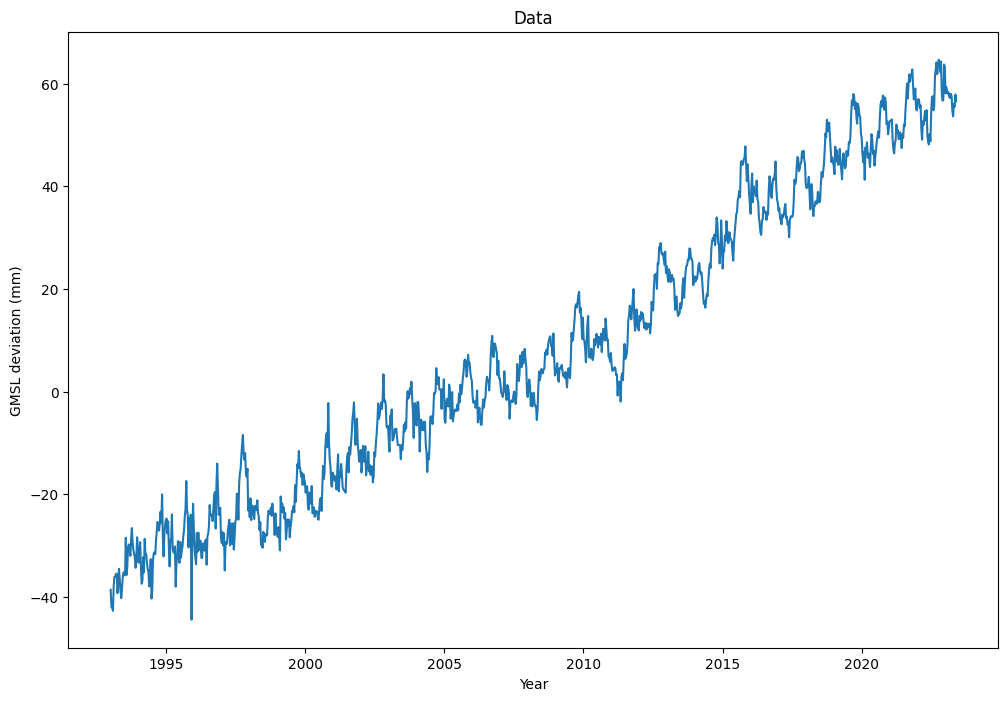

In [4]:
y = data['GMSL'].values
u = data['Year'].values
ndata = len(y)
plt.plot(u,y)
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')
plt.title("Data")
plt.show()

In this lab we will use a structural time series model to analys this data set. Specifically, we assume that the data $\{y_t\}_{t\geq 1}$ is generated by

\begin{align}
    y_t = \mu_t + \gamma_t + \varepsilon_t
\end{align}

where $\mu_t$ is a trend component, $\gamma_t$ is a seasonal component, and $\varepsilon_t$ is an observation noise. The model is expressed using a state space representation,

\begin{align}
    \alpha_{t+1} &= T \alpha_t + R\eta_t, & \eta_t&\sim N(0,Q), \\
    y_t &= Z \alpha_t + \varepsilon_t, & \varepsilon_t&\sim N(0,\sigma_\varepsilon^2).
\end{align}

**Q0:** Let $d = \dim(\alpha_t)$ denote the _state dimension_ and $d_\eta = \dim(\eta_t)$ denote the dimension of the state noise. Then, what are the dimensions of the matrices $T$, $R$, and $Z$ of the state space model?

**A:**
let dim $(\alpha_t)$ = [ A x B]

let dim $(\eta_t)$ = [C X D]

T: [ A X A ]

R: [ A X C]

Z: [1 X A]


**Q1:** Create the state space matrices $T_{[\mu]}$, $R_{[\mu]}$, and $Z_{[\mu]}$ corresponding to the trend component $\mu_t$. We assume a local linear trend (that is, of order $k=2$).

_Hint:_ Use **2-dimensional** `numpy.ndarray`s of the correct sizes to represent all the matrices.

In [5]:
#Lecture 5a, last slide: initialisation of the trend
T_mu = np.array([[2,-1],
                 [1, 0]])
R_mu = np.array([[1],[0]])
Z_mu = np.array([[1,0]])

**Q2:** There is a yearly seasonal pattern present in the data. What should we set the periodicity $s$ of the seasonal component to, to capture this pattern?

_Hint:_ Count the average number of observations per (whole) year and round to the closest integer.

In [6]:
print(u.min()) # Start point (.011526 of the year 1993)
print(u.max()) # decimal palce greater than .011526, so we will stop the year at 2023.011526 to have whole year

data_whole = data[data['Year'] <= 2023.011526]

whole_y = data_whole['GMSL'].values
whole_u = data_whole['Year'].values

print("Average number of observations per year: ")
print(round(len(whole_y)/(whole_u.max()-whole_u.min())))

1993.011526
2023.391272
Average number of observations per year: 
37


Checking for consistency is time intervals: it seems like one measurment is missing in ht emiddle of the data

Text(0, 0.5, 'delta days')

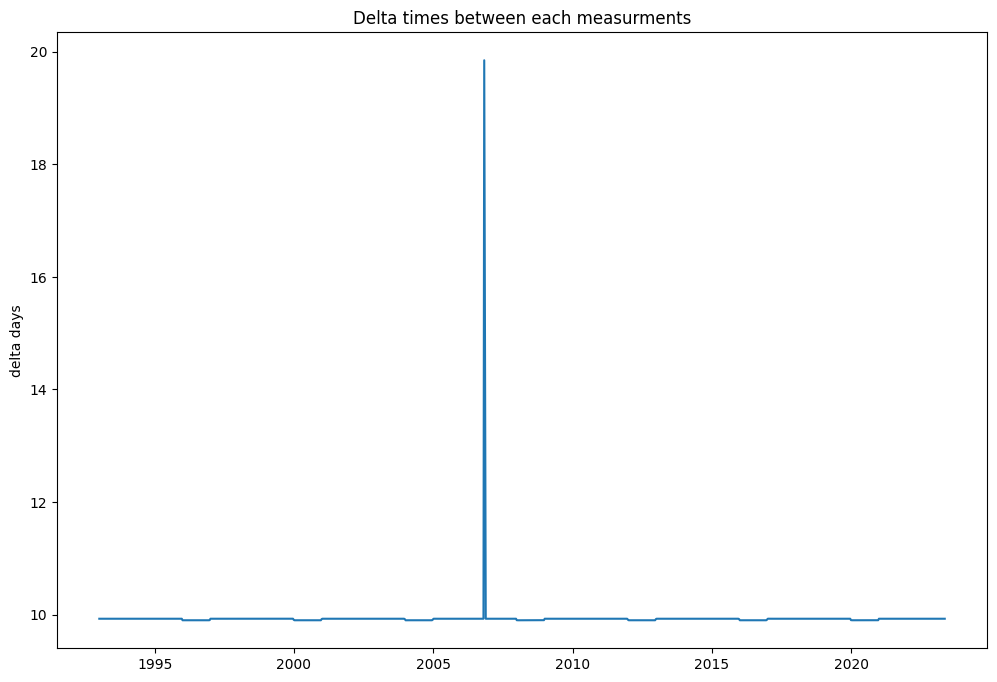

In [7]:
delta = [0]*len(u)
for i in range(len(u)-1):
    delta[i] = (u[i+1]-u[i])/0.002737
plt.plot(u[:-1],delta[:-1])
plt.title("Delta times between each measurments")
plt.ylabel('delta days')

In [8]:
print(whole_u.max())
print(whole_u.min())
print(len(whole_y))


2023.010946
1993.011526
1105


**Q3:** What is the _state dimension_ of a seasonal component with periodicity $s$? That is, how many states are needed in the corresponding state space representation?

**A:** The dimension is going to be [s-1 x 1] so [36 x 1]


**Q4:** Create the state space matrices $T_{[\gamma]}$, $R_{[\gamma]}$, and $Z_{[\gamma]}$ corresponding to the seasonal component $\gamma_t$.

_Hint:_ Use **2-dimensional** `numpy.ndarray`s of the correct sizes to represent all the matrices.

In [9]:
def init_matrix(n):
    matrix = np.zeros((n, n))
    matrix[0, :] = -1
    np.fill_diagonal(matrix[1:], 1)
    return matrix

In [10]:
#Lecture 5b, slide 4: initialisation of the seasonal component
s = 36
T_gamma = init_matrix(s)
#print(f"T_gamma : {T_gamma}")
R_gamma = np.zeros((s,1))
R_gamma[0,] = 1
#print(f"R_gamma : {R_gamma}")
Z_gamma = np.zeros((1,s))
Z_gamma[0,0] = 1
#print(f"Z_gamma : {Z_gamma}")

**Q5:** Using the matrices that you have constructed above, create the state space matrices for the complete structural time series model. Print out the shapes of the resulting system matrices and check that they correspond to what you expect (cf **Q0**).

_Hint:_ Use `scipy.linalg.block_diag` and `numpy.concatenate`.

In [11]:
from scipy import linalg
T = linalg.block_diag(T_mu, T_gamma)
R = linalg.block_diag(R_mu, R_gamma)
Z = np.concatenate((Z_mu, Z_gamma), axis=1)

In [12]:
print(T.shape)
print(R.shape)
print(Z)

(38, 38)
(38, 2)
[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


We also need to specify the variances of the process noise $\eta_t$ and measurement noise $\varepsilon_t$. Below, we will estimate (two of) these variances from data, but for now we set them arbitrarily to get an initial model to work with.

In [13]:
# Some arbitrary noise values for now
sigma_trend = 0.01
sigma_seas = 1
sigma_eps = 1
Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas**2]])  # Process noise covariance matrix

In [14]:
print(Q)

[[1.e-04 0.e+00]
 [0.e+00 1.e+00]]


Finally, to complete the model we need to specify the distribution of the initial state. This encodes our _a priori_ belief about the actual values of the trend and seasonality, i.e., before observing any data.

**Q6:** Set up the mean vector of the initial state $a_1 = \mathbb{E}[\alpha_1]$ such that:
* The trend component starts at the first observation, $\mathbb{E}[\mu_1] = y_1$,
* The slope of the trend is _a priori_ zero in expectation, $\mathbb{E}[\mu_1 - \mu_0] = 0$,
* The initial mean of all states related to the seasonal component are zero.

Also, create an initial state covariance matrix $P_1 = \text{Cov}(\alpha_1)$ as an identity matrix of the correct dimension, multiplied with a large value (say, 100) to represent our uncertainty about the initial state.

In [15]:
print(whole_y[1])

-42.01


In [16]:
a1 = np.array((whole_y[1]))
print(a1)
P1 = np.identity(s+2)*100
print(P1)

-42.01
[[100.   0.   0. ...   0.   0.   0.]
 [  0. 100.   0. ...   0.   0.   0.]
 [  0.   0. 100. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 100.   0.   0.]
 [  0.   0.   0. ...   0. 100.   0.]
 [  0.   0.   0. ...   0.   0. 100.]]


We have now defined all the matrices etc. that make up the structural state space model. For convenience, we can create an object of the class `LGSS` available in the module `tssltools_lab2` as a container for these quantities.

In [17]:
from tssltools_lab2 import LGSS
model = LGSS(T, R, Q, Z, sigma_eps**2, a1, P1)

help(model.get_params)

Help on method get_params in module tssltools_lab2:

get_params() method of tssltools_lab2.LGSS instance
    Return all model parameters.
    
    T, R, Q, Z, H, a1, P1 = model.get_params()



## 2.2 Kalman filtering for the structural model
Now we have the data and a model available. Next, we will turn our attention to the inference problem, which is a central task when analysing time series data using the state space framework.

State inference is the problem of estimating the unknown (latent) state variables given the data. For the time being we assume that the _model parameters_ are completely specified, according to above, and only consider how to estimate the states using the Kalman filter.

In the questions below we will treat the first $n=800$ time steps as training data and the remaining $m$ observations as validation data.

In [18]:
n = 800
m = len(whole_y)-n


**Q7:** Complete the Kalman filter implementation below. The function should be able to handle missing observations, which are encoded as "not a number", i.e. `y[t] = np.nan` for certain time steps `t`.

_Hint:_ The Kalman filter involves a lot of matrix-matrix and matrix-vector multiplications. It turns out to be convient to store sequences of vectors (such as the predicted and filtered state estimates) as `(d,1,n)` arrays, instead of `(d,n)` or `(n,d)` arrays. In this way the matrix multiplications will result in 2d-arrays of the correct shapes without having to use a lot of explicit `reshape`. However, clearly, this is just a matter of coding style preferences!

In [19]:
nill = np.zeros(m)
nill[:] = np.nan
y_final = np.concatenate((whole_y[0:800],nill))
n = len(y_final)

d = model.d  # State dimension
alpha_pred = np.zeros((d, 1, n))
P_pred = np.zeros((d, d, n))
alpha_filt = np.zeros((d, 1, n))
P_filt = np.zeros((d, d, n))
y_pred = np.zeros(n)
F_pred = np.zeros(n)

T, R, Q, Z, H, a1, P1 = model.get_params()


In [20]:
alpha_pred[:,:,0] = a1
P_pred[:,:,0] = P1

for i in range(1,n):

  alpha_pred[:,:,i]  = T @ alpha_filt[:,:,i-1]
  P_pred[:,:,i] = T @ P_filt[:,:,i-1] @ T.T + R @ Q @ R.T

  y_pred[i] = Z @ alpha_pred[:,:,i]
  F_pred[i-1] = Z @ P_pred[:,:,i] @ Z.T + sigma_eps

  if np.isnan(y_final[i]) == False:
    K_t = (P_pred[:,:,i] @ Z.T) * (1/F_pred[i-1])

    alpha_filt[:,:,i] = alpha_pred[:,:,i] + K_t * (y_final[i] - y_pred[i])
    P_filt[:,:,i] = (np.identity(d) - K_t @ Z) @ P_pred[:,:,i]
  else:
    alpha_filt[:,:,i] = alpha_pred[:,:,i]
    P_filt[:,:,i] = P_pred[:,:,i]

<ipython-input-20-208a25995f38>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = Z @ alpha_pred[:,:,i]
<ipython-input-20-208a25995f38>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_pred[i-1] = Z @ P_pred[:,:,i] @ Z.T + sigma_eps


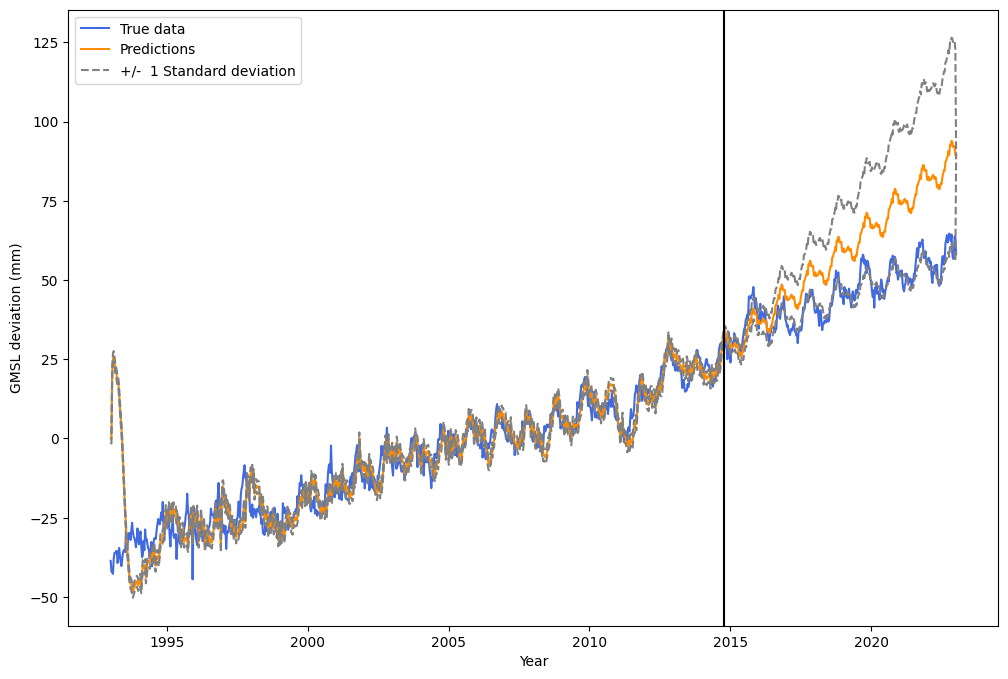

In [21]:
plt.plot(whole_u,whole_y, color = "royalblue")

plt.plot(whole_u,y_pred, color = "darkorange")
plt.plot(whole_u,y_pred  + np.sqrt(F_pred),"--", color="grey")
plt.plot(whole_u,y_pred - np.sqrt(F_pred),"--", color="grey")

plt.axvline(x=whole_u[800], color="black")
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')
plt.legend(['True data',"Predictions","+/-  1 Standard deviation"])
plt.show()

In [22]:
from tssltools_lab2 import kfs_res

def kalman_filter(y, model: LGSS):
    """Kalman filter for LGSS model with one-dimensional observation.

    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.

    :return kfs_res: Container class with member variables,
        alpha_pred: (d,1,n) array of predicted state means.
        P_pred: (d,d,n) array of predicted state covariances.
        alpha_filt: (d,1,n) array of filtered state means.
        P_filt: (d,d,n) array of filtered state covariances.
        y_pred: (n,) array of means of p(y_t | y_{1:t-1})
        F_pred: (n,) array of variances of p(y_t | y_{1:t-1})
    """

    n = len(y)
    d = model.d  # State dimension
    alpha_pred = np.zeros((d, 1, n))
    P_pred = np.zeros((d, d, n))
    alpha_filt = np.zeros((d, 1, n))
    P_filt = np.zeros((d, d, n))
    y_pred = np.zeros(n)

    F_pred = np.zeros(n)
    sigma_eps = 1

    T, R, Q, Z, H, a1, P1 = model.get_params()  # Get all model parameters (for brevity)

    alpha_pred[0][0][0] = a1

    P_pred[:,:,0] = P1
    for t in range(n):
        #print("------- iteration:",t, "--------------", end="\r")
        # Time update (Predict)
        if(t==0):
            alpha_pred[0][0][0] = a1
            P_pred[:,:,0] = P1
        else:
            alpha_pred[:,:,t] = T @ alpha_filt[:,:,t-1]
            P_pred[:,:,t] = T @ P_filt[:,:,t-1] @ T.T + R @ Q @ R.T

        # Compute prediction of current output
        y_pred[t] = Z @ alpha_pred[:,:,t]
        F_pred[t] = Z @ P_pred[:,:,t] @ Z.T + H
        # Measurement update (correct)
        if not np.isnan(y[t]):
            K_t = P_pred[:,:,t] @ Z.T * (1/(F_pred[t]))
            alpha_filt[:,:,t] = alpha_pred[:,:,t] + K_t *(y[t] - y_pred[t])
            P_filt[:,:,t] = (np.identity(s+2) - K_t @ Z)@ P_pred[:,:,t]
        else:
            #print(t)
            #if missing value, skip the update
            alpha_filt[:,:,t] = alpha_pred[:,:,t]
            P_filt[:,:,t] = P_pred[:,:,t]



    kf = kfs_res(alpha_pred, P_pred, alpha_filt, P_filt, y_pred, F_pred)
    return kf

**Q8:** Use the Kalman filter to infer the states of the structural time series applied to the sealevel data. Run the filter on the training data (i.e., first $n=800$ time steps), followed by a long-range prediction of $y_t$ for the remaining time points.

Generate a plot which shows:
1. The data $y_{1:n+m}$,
2. The one-step predictions $\hat y_{t|t-1} \pm 1 $ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The long-range predictions $\hat y_{t|n} \pm 1 $ standard deviation for the validation data, i.e., $t= n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

_Hint:_ It is enough to call the `kalman_filter` function once. Make use of the missing data functionality!

In [27]:
n = len(whole_y)
nans=np.empty((n-800))
nans[:] = np.nan
kf = kalman_filter(np.concatenate((whole_y[0:800],nans)), model)

<ipython-input-22-3287020141c9>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[t] = Z @ alpha_pred[:,:,t]
<ipython-input-22-3287020141c9>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_pred[t] = Z @ P_pred[:,:,t] @ Z.T + H


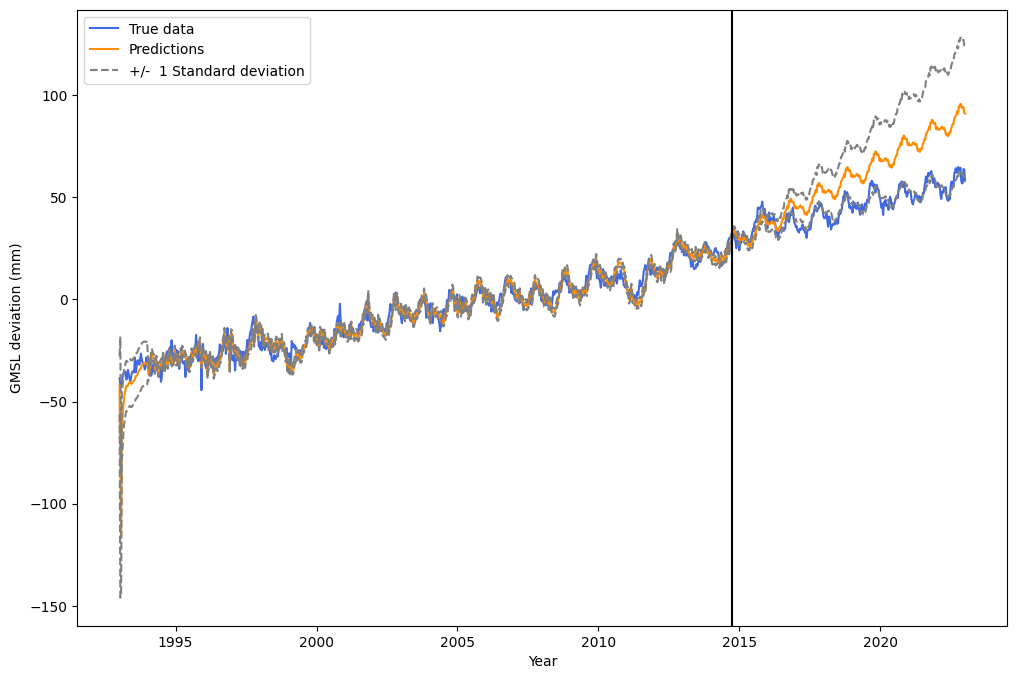

In [28]:
#One step prediction +/- 1 std
preds = kf.y_pred
#Long-range prediction +/- 1 std

#print(kf.alpha_pred)
#y = data['GMSL'].values
#u = data['Year'].values
#ndata = len(y)
plt.plot(whole_u,whole_y, color = "royalblue")

plt.plot(whole_u,preds, color = "darkorange")
plt.plot(whole_u,preds  + np.sqrt(kf.F_pred),"--", color="grey")
plt.plot(whole_u,preds - np.sqrt(kf.F_pred),"--", color="grey")

plt.axvline(x=whole_u[800], color="black")
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')
plt.legend(['True data',"Predictions","+/-  1 Standard deviation"])
plt.show()

**Q9:** Based on the output of the Kalman filter, compute the training data log-likelihood $\log p(y_{1:n})$.

In [29]:
import math

def log_like(kf,nrange):
    like= 0
    for i in nrange:

        like += math.log(abs(kf.F_pred[i])) + ((y[i]-kf.y_pred[i])**2)/(kf.F_pred[i])


    final_like = -like/2

    return final_like

log_like(kf,range(0,800))

-2258.254966664664

## 2.3 Identifying the noise variances using the EM algorithm
So far we have used fixed model parameters when running the filter. In this section we will see how the model parameters can be learnt from data using the EM algorithm. Specifically, we will try to learn the variance of the state noise affecting the seasonal component as well as the variance of the observation noise,

\begin{align}
    \theta = (\sigma_\gamma^2, \sigma_\varepsilon^2).
\end{align}

For brevity, the variance of the trend component $\sigma_\mu^2$ is fixed to the value $\sigma_\mu^2 = 0.01^2$ as above. (See Appendix A below for an explanation.)

Recall that we consider $y_{1:n}$ as the training data, i.e., we will estimate $\theta$ using only the first $n=800$ observations.

**Q10:** Which optimization problem is it that the EM algorithm is designed to solve? Complete the line below!

**A:** $\hat\theta = \arg\max_{\theta} E(log(\theta \mid  y))$

E(log(theta given data))

**Q11:** Write down the updating equations on closed form for the M-step in the EM algorithm.

_Hint: Look at Exercise Session 2_

**A:**
\begin{align}
    \frac{\partial Q(\theta, \tilde\theta) }{\partial \sigma_\gamma^2} = \frac{1}{ \sigma_\gamma^2}-\frac{\sum_{t=1}^n\{\hat\eta_{t\mid n}\hat\eta_{t\mid n}^T +Var[\eta_{t}\mid y_{1:n}] \}}{\sigma_\gamma^4} = 0
\end{align}
    
Thus,
\begin{align}
    \sigma_\gamma^2 = \frac{1}{n} \sum_{t=1}^n\{{\hat\eta_{t\mid n}\hat\eta_{t\mid n}^T + Var[\eta_{t}\mid y_{1:n}] \}}
\end{align}

Then,
\begin{align}
    \frac{\partial Q(\theta, \tilde\theta) }{\partial \sigma_\epsilon^2} = \frac{1}{ \sigma_\epsilon^2}-\frac{\sum_{t=1}^n\{\hat\epsilon_{t\mid n}^2 +Var[\epsilon_{t}\mid y_{1:n}] \}}{\sigma_\epsilon^4} = 0
\end{align}

Thus,
\begin{align}
    \sigma_\epsilon^2 = \frac{1}{n} \sum_{t=1}^n\{\hat\epsilon_{t\mid n}^2 + Var[\epsilon_{t}\mid y_{1:n}] \}
\end{align}

To implement the EM algorithm we need to solve a _smoothing problem_. The Kalman filter that we implemented above is based only on a forward propagation of information. The _smoother_ complements the forward filter with a backward pass to compute refined state estimates. Specifically, the smoothed state estimates comprise the mean and covariances of

\begin{align}
    &p(\alpha_t \mid y_{1:n}), & t=&1,\dots,n
\end{align}

Furthermore, when implementing the EM algorithm it is convenient to work with the (closely related) smoothed estimates of the disturbances, i.e., the state and measurement noise,

\begin{align}
    &p(\eta_t \mid y_{1:n}), & t=&1,\dots,n-1 \\
    &p(\varepsilon_t \mid y_{1:n}), & t=&1,\dots,n
\end{align}

An implementation of a state and disturbance smoother is available in the `tssltools_lab2` module. You may use this when implementing the EM algorithm below.


In [30]:
from tssltools_lab2 import kalman_smoother
help(kalman_smoother)

Help on function kalman_smoother in module tssltools_lab2:

kalman_smoother(y, model: tssltools_lab2.LGSS, kf: tssltools_lab2.kfs_res)
    Kalman (state and disturbance) smoother for LGSS model with one-dimensional observation.
    
    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    :parma kf: kfs_res object with result from a Kalman filter foward pass.
    
    :return kfs_res: Container class. The original Kalman filter result is augmented with the following member variables,
        alpha_sm: (d,1,n) array of smoothed state means.
        V: (d,d,n) array of smoothed state covariances.
        eps_hat: (n,) array of smoothed means of observation disturbances.
        eps_var: (n,) array of smoothed variances of observation disturbances.
        eta_hat: (deta,1,n) array of smoothed means of state disturbances.
        eta_cov: (deta,deta,n) array of smoothed covariances of sta

**Q12:** Implement an EM algorithm by completing the code below. Run the algorithm for 100 iterations and plot the traces of the parameter estimates, i.e., the values $\theta_r$, for $r = 0,\dots,100$.

_Note:_ When running the Kalman filter as part of the EM loop you should only filter the _training data_ (i.e. excluding the prediction for validation data).


In [84]:
b = (ks.eta_hat * ks.eta_hat)

In [85]:
b.shape

(2, 1, 800)

In [88]:
f = (ks.eta_hat * ks.eta_hat) + ks.eta_cov

In [89]:
f.shape

(2, 2, 800)

In [ ]:
num_iter = 50

sigma_trend = 0.01
sigma_seas = 1
sigma_eps = 1
Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas**2]])  # Process noise covariance matrix
n = 800

for k in range(num_iter):
  #E-step
  kf = kalman_filter(whole_y[0:800], model)
  ks = kalman_smoother(np.concatenate((whole_y[0:800],nans)), model, kf)

  log_like_plot = log_like(kf,range(0,800))


  #M-step

  sigma_eps_plot = (np.sum(ks.eps_hat**2 + ks.eps_var))/n

  sigma_seas_plot = (np.sum((ks.eta_hat * ks.eta_hat) + ks.eta_cov, axis=2))/n


In [86]:
num_iter = 50

sigma_trend = 0.01
sigma_seas = 1
sigma_eps = 1
Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas**2]])  # Process noise covariance matrix
n = 800

eps_plot = np.zeros((num_iter))
seas_plot = np.zeros((num_iter))
logs = np.zeros((num_iter))
log_like_old = 0
stopping_criterion = 0.01
stopping_r = 0
for r in range(1,num_iter):
    # E-step
    Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas**2]])  # Process noise covariance matrix

    model = LGSS(T, R, Q, Z, sigma_eps**2, a1, P1)

    kf = kalman_filter(whole_y[0:800], model)
    smoother = kalman_smoother(whole_y[0:800],model,kf)

    log_like_new = log_like(kf,range(0,800))
    print(f"iteration {r} loglik: {log_like_new}")
    logs[r] = log_like_new
    #Stopping condition if loglikelihood doesnt improve
    if(abs(log_like_new - log_like_old) < stopping_criterion): break

    # M-step
    sigma_eps = np.sqrt(np.mean(smoother.eps_hat**2 + smoother.eps_var))
    eps_plot[r] = sigma_eps

    sigma_seas = np.mean((smoother.eta_hat * smoother.eta_hat) + smoother.eta_cov, axis=2)  ###### Any reason why we are doing * and not @ since it is matrix multiplication ? so it should still work right?
    sigma_seas = np.sqrt(sigma_seas[1][1])
    seas_plot[r] = sigma_seas

    log_like_old = log_like_new
    stopping_r = r

<ipython-input-22-3287020141c9>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[t] = Z @ alpha_pred[:,:,t]
<ipython-input-22-3287020141c9>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_pred[t] = Z @ P_pred[:,:,t] @ Z.T + H


iteration 1 loglik: -2258.254966664664
iteration 2 loglik: -1625.5478972249305
iteration 3 loglik: -1521.208773114243
iteration 4 loglik: -1495.4518788985133
iteration 5 loglik: -1485.7156404685552
iteration 6 loglik: -1479.5689248941687
iteration 7 loglik: -1474.6332453238742
iteration 8 loglik: -1470.4008165549055
iteration 9 loglik: -1466.6990056768223
iteration 10 loglik: -1463.4278701748483
iteration 11 loglik: -1460.5144643148976
iteration 12 loglik: -1457.9020407220085
iteration 13 loglik: -1455.5454582987343
iteration 14 loglik: -1453.4083090840702
iteration 15 loglik: -1451.4608890928653
iteration 16 loglik: -1449.6787132726913
iteration 17 loglik: -1448.0414090840288
iteration 18 loglik: -1446.5318805544412
iteration 19 loglik: -1445.1356687403934
iteration 20 loglik: -1443.8404568127514
iteration 21 loglik: -1442.6356829961383
iteration 22 loglik: -1441.512234888677
iteration 23 loglik: -1440.462205857068
iteration 24 loglik: -1439.4786992607792
iteration 25 loglik: -1438.55

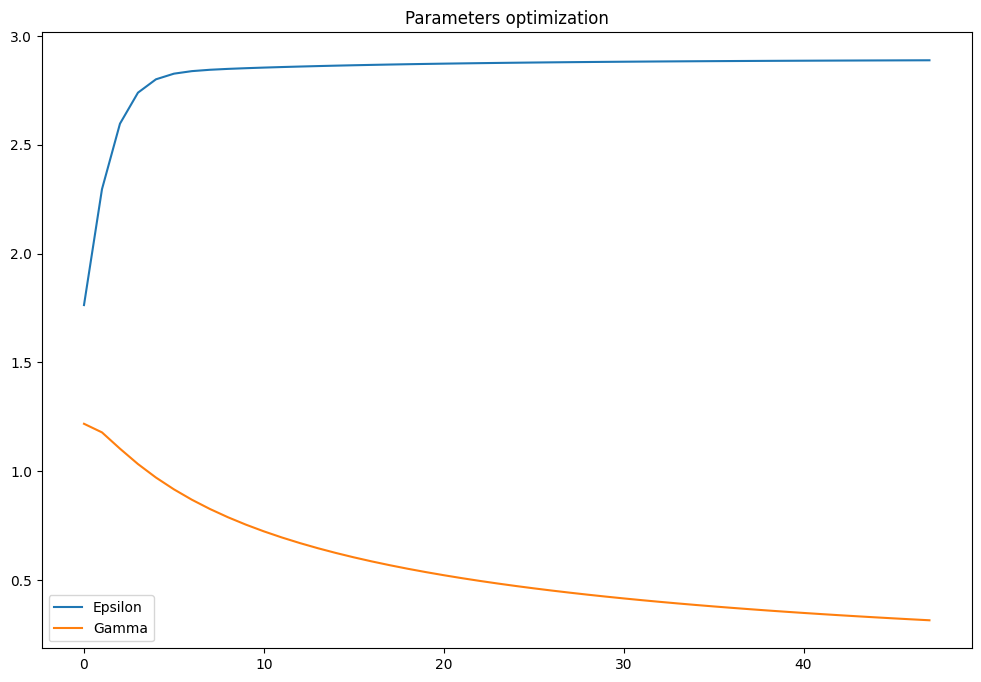

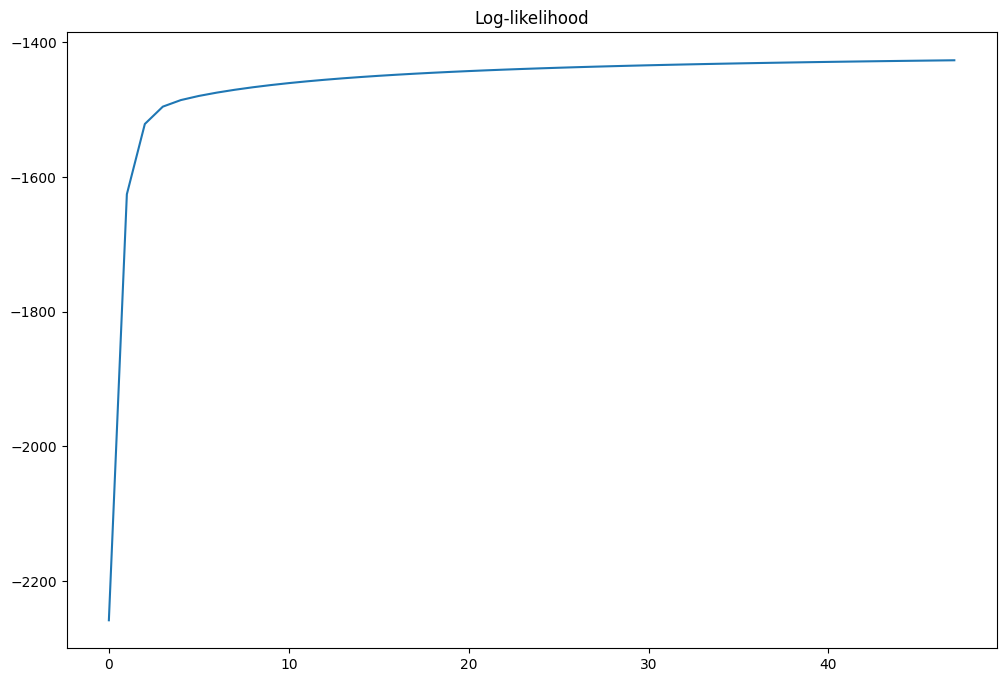

In [90]:

plt.plot(eps_plot[1:stopping_r])
plt.plot(seas_plot[1:stopping_r])
plt.title("Parameters optimization")
plt.legend(['Epsilon',"Gamma"])
plt.show()


plt.plot(logs[1:stopping_r])
plt.title("Log-likelihood")
plt.show()

## 2.4 Further analysing the data
We will now fix the model according to the final output from the EM algorithm and further analyse the data using this model.

**Q13:** Rerun the Kalman filter to compute a _long range prediction for the validation data points,_ analogously to **Q8** (you can copy-paste code from that question). That is, generate a plot which shows:
1. The data $y_{1:n+m}$,
2. The one-step predictions $\hat y_{t|t-1} \pm 1 $ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The long-range predictions $\hat y_{t|n} \pm 1 $ standard deviation for the validation data, i.e., $t= n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

Furthermore, compute the training data log-likelihood $\log p(y_{1:n})$ using the estimated model (cf. **Q9**).

In [91]:
# Some arbitrary noise values for now
sigma_trend = 0.01
sigma_seas = seas_plot[stopping_r]
sigma_eps = eps_plot[stopping_r]


Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas**2]])  # Process noise covariance matrix


n = len(whole_y)
nans=np.empty((n-800))
nans[:] = np.nan
model_EM = LGSS(T, R, Q, Z, sigma_eps**2, a1, P1)
kf_em = kalman_filter(np.concatenate((whole_y[0:800],nans)), model_EM)

<ipython-input-22-3287020141c9>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[t] = Z @ alpha_pred[:,:,t]
<ipython-input-22-3287020141c9>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_pred[t] = Z @ P_pred[:,:,t] @ Z.T + H


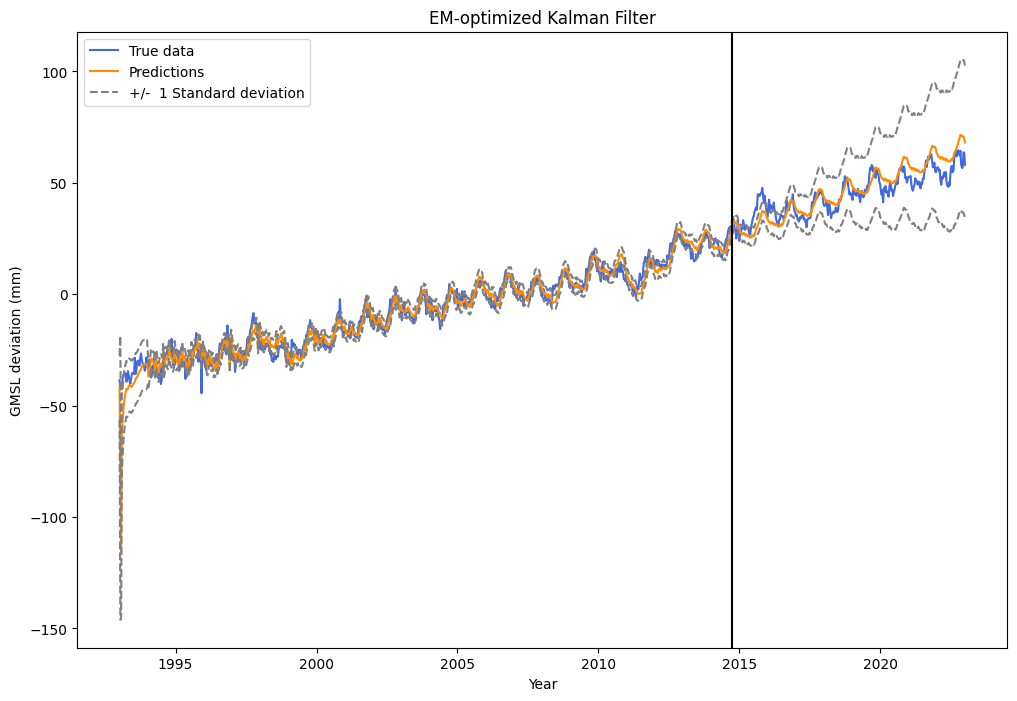

In [92]:
#One step prediction +/- 1 std
preds_em = kf_em.y_pred
#Long-range prediction +/- 1 std

#print(kf.alpha_pred)
#y = data['GMSL'].values
#u = data['Year'].values
#ndata = len(y)
plt.plot(whole_u,whole_y, color="royalblue")

plt.plot(whole_u,preds_em, color="darkorange")
plt.plot(whole_u,preds_em  + np.sqrt(kf_em.F_pred),"--", color="grey")
plt.plot(whole_u,preds_em - np.sqrt(kf_em.F_pred),"--", color="grey")

plt.axvline(x=whole_u[800], color="black")
plt.title("EM-optimized Kalman Filter")
plt.legend(['True data',"Predictions","+/-  1 Standard deviation"])
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')
plt.show()

In [93]:
log_like(kf_em, range(800))

-1426.025121366732

In [94]:
log_like(kf_em, range(800,1105))

-847.7316499235492

Note that we can view the model for the data $y_t$ as being comprised of an underlying "signal", $s_t = \mu_t + \gamma_t$ plus observation noise $\varepsilon_t$

\begin{align}
    y_t = s_t + \varepsilon_t
\end{align}

We can obtain refined, _smoothed,_ estimates of this signal by conditioning on all the training data $y_{1:n}$.

**Q14:** Run a Kalman smoother to compute smoothed estimates of the signal, $\mathbb{E}[s_t | y_{1:n}]$, conditionally on all the _training data_. Then, similarly to above, plot the following:
1. The data $y_{1:n+m}$,
2. The smoothed estimates $\mathbb{E}[s_t | y_{1:n}] \pm 1 $ standard deviation for the training data, i.e., $t = 1,...,n$,
3. The predictions $\mathbb{E}[s_t | y_{1:n}] \pm 1 $ standard deviation for the validation data, i.e., $t = n+1,...,n+m$,
4. A vertical line indicating the switch between training and validation data, using `plt.axvline(x=u[n])`.

_Hint:_ Express $s_t$ in terms of $\alpha_t$. Based on this expression, compute the smoothed mean and variance of $s_t$ based on the smoothed mean and covariance of $\alpha_t$.

<ipython-input-22-3287020141c9>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[t] = Z @ alpha_pred[:,:,t]
<ipython-input-22-3287020141c9>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_pred[t] = Z @ P_pred[:,:,t] @ Z.T + H
<ipython-input-95-07308141773c>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_preds[i] = Z @ alpha_smoothed[:,:,i]


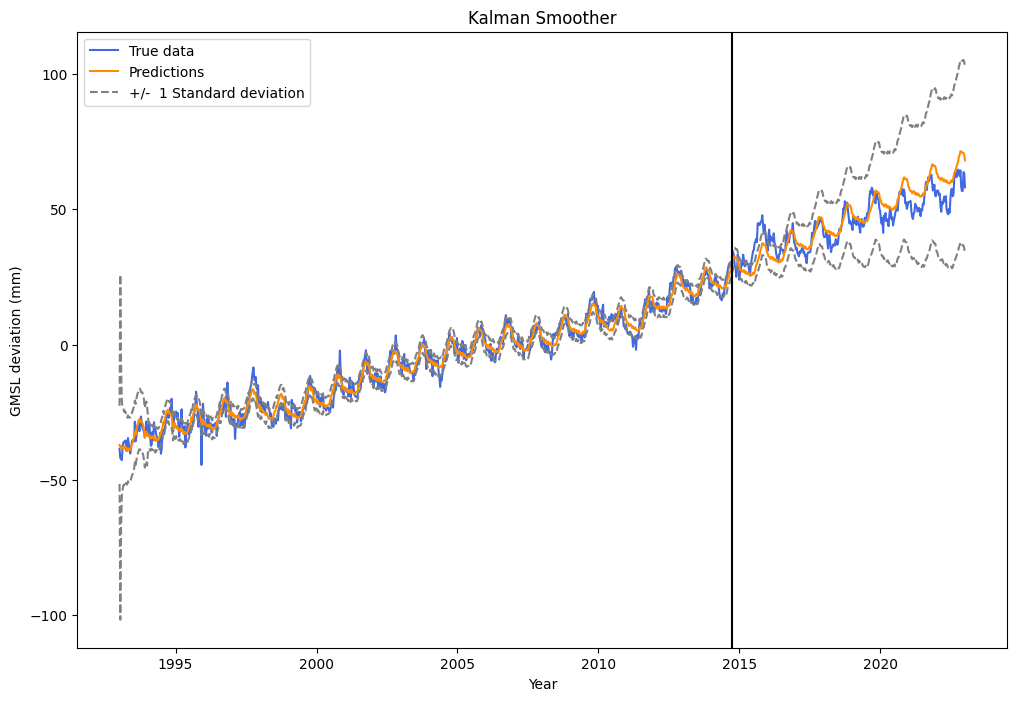

In [95]:
sigma_trend = 0.01
sigma_seas = seas_plot[stopping_r]
sigma_eps = eps_plot[stopping_r]


Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas**2]])  # Process noise covariance matrix

n = len(whole_y)
nans=np.empty((n-800))
nans[:] = np.nan
model = LGSS(T, R, Q, Z, sigma_eps**2, a1, P1)
kf = kalman_filter(np.concatenate((whole_y[0:800],nans)), model)

ks = kalman_smoother(np.concatenate((whole_y[0:800],nans)),model,kf)


alpha_smoothed = ks.alpha_sm
s_preds = np.empty(1105)
for i in range(1105):
    s_preds[i] = Z @ alpha_smoothed[:,:,i]

#print(sum(s_preds-kf.y_pred))
plt.plot(whole_u,whole_y, color="royalblue")
plt.plot(whole_u,s_preds, color="darkorange")

plt.plot(whole_u,s_preds + np.sqrt(ks.F_pred),"--", color="grey")
plt.plot(whole_u,s_preds - np.sqrt(ks.F_pred),"--", color="grey")

plt.title("Kalman Smoother")
plt.legend(['True data',"Predictions","+/-  1 Standard deviation"])
plt.axvline(x=whole_u[800], color="black")
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')
plt.show()

In [ ]:
import math

def log_like_ks(ks,nrange,s_preds):
    like= 0
    for i in nrange:

        like += math.log(abs(ks.F_pred[i])) + ((y[i]-s_preds[i])**2)/(ks.F_pred[i])


    final_like = -like/2

    return final_like

log_like_ks(ks,range(0,800),s_preds)

-1267.8120951517642

In [ ]:
log_like_ks(ks,range(800,1105),s_preds)

-847.7316499235492

**Q15:** Explain, using a few sentences, the qualitative differences (or similarities) between the Kalman filter predictions plotted in **Q13** and the smoothed signal estimates plotted in **Q14** for,
1. Training data points, $t \leq n$
2. Validation data points, $t > n$

**A:** Based on the plots, we can see that the smoothed signal estimates performs better than the kalman filter perdictions as it takes past and future observations into account through the forward and backward pass for the training data, this is supported by the the log-likelihood values as printed above.

While for the validation data points, we dont see any change in the graph and also in the log-likelihoods.


We can shed additional light on the properties of the process under study by further decomposing the signal into its trend and seasonal components.

**Q16:** Using the results of the state smoother, compute and plot the _smoothed estimates_ of the two signal components, i.e.:

1. Trend: $\hat \mu_{t|n} = \mathbb{E}[\mu_t | y_{1:n}]$ for $t = 1,\dots,n$
2. Seasonal: $\hat \gamma_{t|n} = \mathbb{E}[\gamma_t | y_{1:n}]$ for $t = 1,\dots,n$

_(You don't have to include confidence intervals here if don't want to, for brevity.)_

In [105]:
ks.V.shape

(38, 38, 1105)

In [100]:
trend = ks.alpha_sm[0:2,:,:]
a = np.mean(trend, axis = 0).T

seasonal = ks.alpha_sm[2:,:,:]
b = np.mean(seasonal, axis = 0).T *100

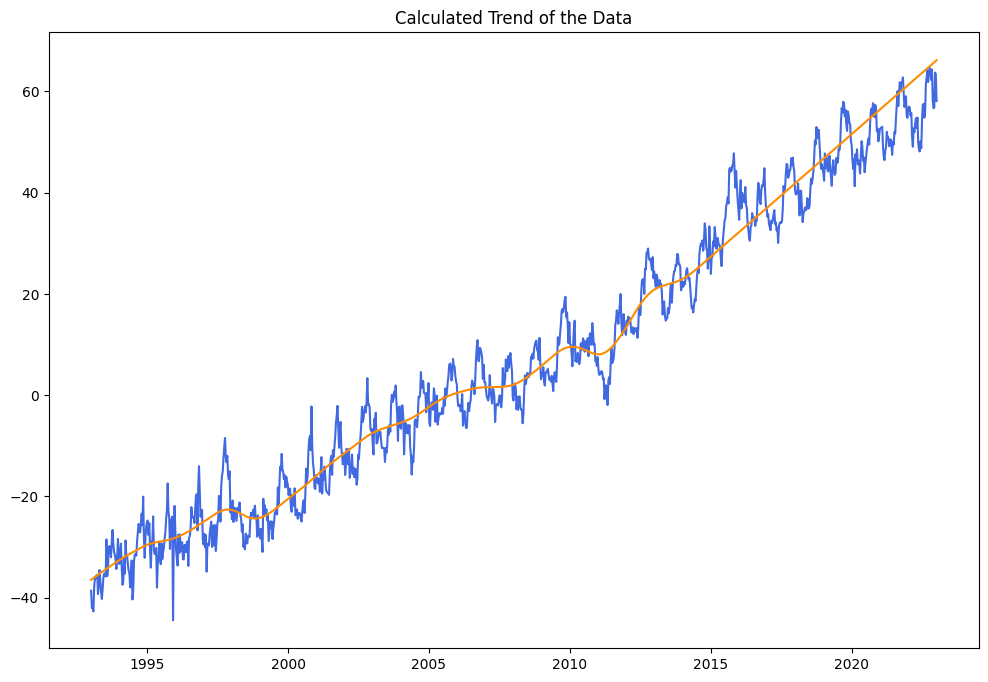

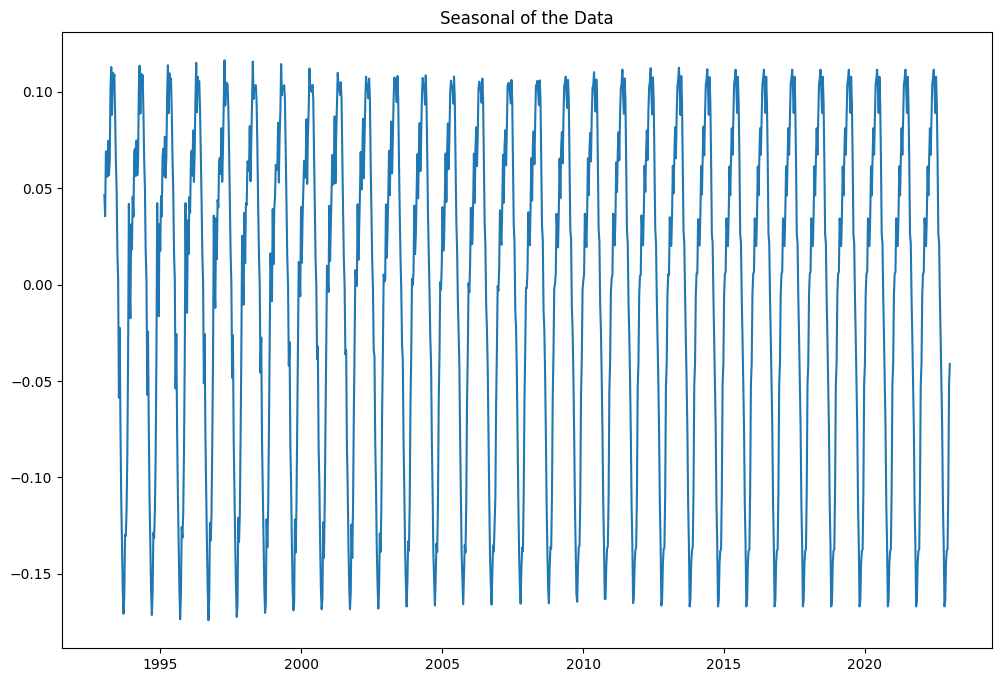

In [101]:

plt.plot(whole_u,whole_y, color = "royalblue")
plt.plot(whole_u,a, color="darkorange")
plt.title("Calculated Trend of the Data")
plt.show()
plt.plot(whole_u,b)
plt.title("Seasonal of the Data")
plt.show()

## 2.5 Missing data
We conclude this section by illustrating one of the key merits of the state space approach to time series analysis, namely the simplicity of handling missing data. To this end we will assume that a chunk of observations in the middle of the training data is missing.

**Q17:** Let the values $y_{t}$ for $ 300 < t \leq 400$ be missing. Modify the data and rerun the Kalman filter and smoother. Plot,
1. The Kalman filter predictions, analogously to **Q8**
2. The Kalman smoother predictions, analogously to **Q13**

Comment on the qualitative differences between the filter and smoother estimates and explain what you see (in a couple of sentences).

<ipython-input-22-3287020141c9>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[t] = Z @ alpha_pred[:,:,t]
<ipython-input-22-3287020141c9>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_pred[t] = Z @ P_pred[:,:,t] @ Z.T + H


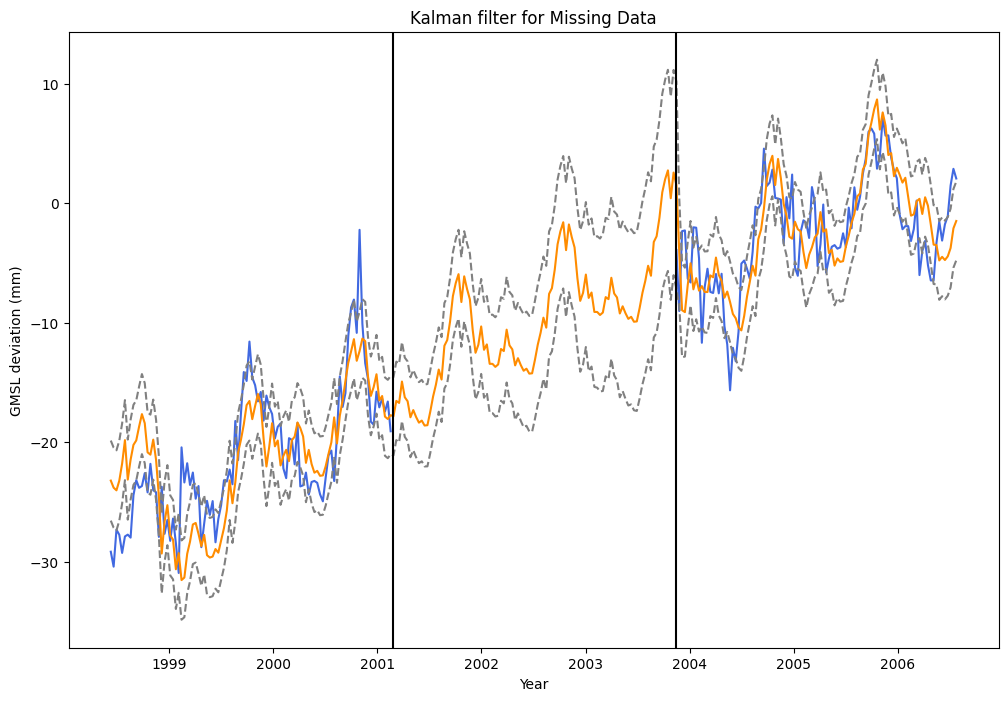

<ipython-input-40-e57ab3bdb370>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s_preds[i] = Z @ alpha_smoothed[:,:,i]


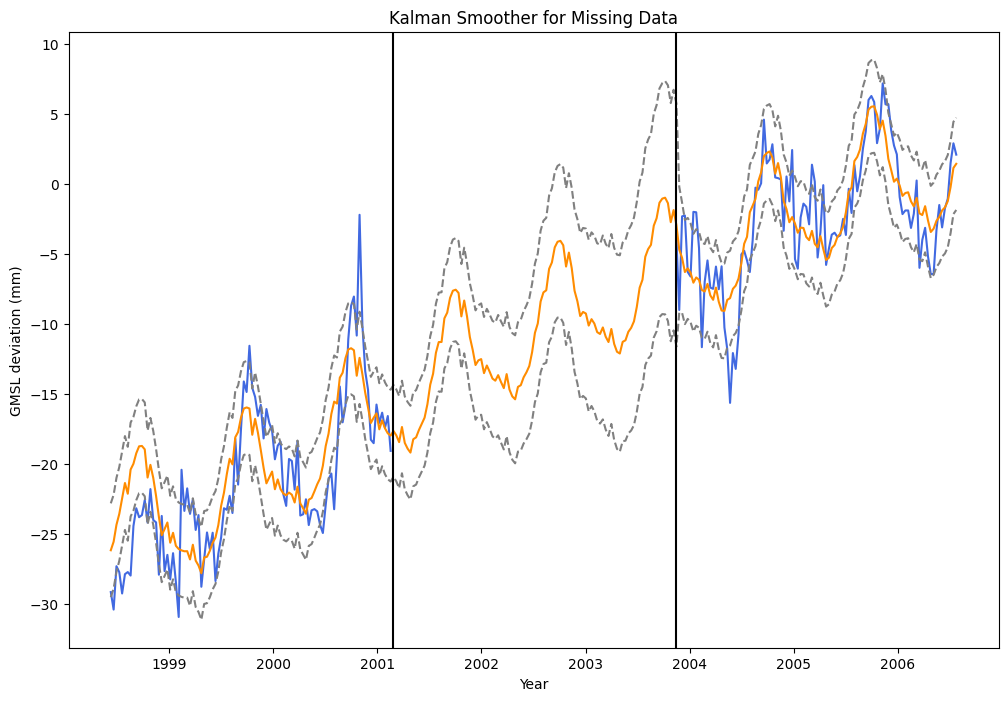

In [ ]:
sigma_trend = 0.01
sigma_seas = seas_plot[stopping_r]
sigma_eps = eps_plot[stopping_r]


Q = np.array([[sigma_trend**2, 0.], [0., sigma_seas**2]])  # Process noise covariance matrix
hole_y = whole_y
hole_y[300:400] = np.nan


model = LGSS(T, R, Q, Z, sigma_eps**2, a1, P1)
kf = kalman_filter(hole_y, model)

plt.plot(whole_u[200:500],hole_y[200:500], color="royalblue")
plt.plot(whole_u[200:500],kf.y_pred[200:500]  + np.sqrt(kf.F_pred[200:500]),"--", color="grey")
plt.plot(whole_u[200:500],kf.y_pred[200:500] - np.sqrt(kf.F_pred[200:500]),"--", color="grey")
plt.plot(whole_u[200:500],kf.y_pred[200:500], color="darkorange")
plt.axvline(x=whole_u[400], color="black")
plt.axvline(x=whole_u[300], color="black")
plt.title("Kalman filter for Missing Data")
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')
plt.show()

ks = kalman_smoother(hole_y,model,kf)


alpha_smoothed = ks.alpha_sm
s_preds = np.empty(1105)
for i in range(1105):
    s_preds[i] = Z @ alpha_smoothed[:,:,i]

#print(sum(s_preds-kf.y_pred))
plt.plot(whole_u[200:500],hole_y[200:500], color="royalblue")

plt.plot(whole_u[200:500],s_preds[200:500] + np.sqrt(ks.F_pred[200:500]),"--", color="grey")
plt.plot(whole_u[200:500],s_preds[200:500] - np.sqrt(ks.F_pred[200:500]),"--", color="grey")
plt.plot(whole_u[200:500],s_preds[200:500], color="darkorange")
plt.axvline(x=whole_u[400], color="black")
plt.axvline(x=whole_u[300], color="black")
plt.title("Kalman Smoother for Missing Data")
plt.xlabel('Year')
plt.ylabel('GMSL deviation (mm)')
plt.show()

We see that the smoother estimates has more variance during this period compared to the kalman filter estimate as it takes past and future data into account so it takes that into account for the varaince.

Also at t = 400, the smoother has a smooth transition between missing data and the next known data while the filter has a abrupt transition.


## Appendix A. Why didn't we learn the trend noise variance as well?
In the assignment above we have fixed $\sigma_\mu$ to a small value. Conceptually it would have been straightforward to learn also this parameter with the EM algorithm. However, unfortunately, the maximum likelihood estimate of $\sigma_\mu$ often ends up being too large to result in accurate _long term predictions_. The reason for this issue is that the structural model

\begin{align}
    y_t = \mu_t + \gamma_t + \varepsilon_t
\end{align}

is not a perfect description of reality. As a consequence, when learning the parameters the mismatch between the model and the data is compensated for by increasing the noise variances. This results in a trend component which does not only capture the long term trends of the data, but also seemingly random variations due to a model misspecification, possibly resulting in poor _long range predictions_.

Kitagawa (Introduction to Time Series Modeling, CRC Press, 2010, Section 12.3) discusses this issue and proposes two solutions. The first is a simple and pragmatic one: simply fix $\sigma_\mu^2$ to a value smaller than the maximum likelihood estimate. This is the approach we have taken in this assignment. The issue is of course that in practice it is hard to know what value to pick, which boild down to manual trial and error (or, if you are lucky, the designer of the lab assignment will tell you which value to use!).

The second, more principled, solution proposed by Kitagawa is to augment the model with a stationary AR component as well. That is, we model

\begin{align}
    y_t = \mu_t + \gamma_t + \nu_t + \varepsilon_t
\end{align}

where $\nu_t \sim \text{AR}(p)$. By doing so, the stationary AR component can compensate for the discrepancies between the original structural model and the "true data generating process". It is straightforward to include this new component in the state space representation (how?) and to run the Kalman filter and smoother on the resulting model. Indeed, this is one of the beauties with working with the state space representation of time series data! However, the M-step of the EM algorithm becomes a bit more involved if we want to use the method to estimate also the AR coefficients of the $\nu$-component, which is beyond the scope of this lab assignment.